# Advent of code 2016

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2016/advent_of_code_2016.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2016/advent_of_code_2016.ipynb)
by [Hugues Hoppe](http://hhoppe.com/) with Python solutions to the
[2016 Advent of Code puzzles](https://adventofcode.com/2016),
completed in December 2022.

We explore both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 1 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results (obtained by setting `SHOW_BIG_MEDIA = True`):

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-ocr advent-of-code-hhoppe hhoppe-tools mediapy more-itertools numba

In [3]:
from __future__ import annotations

# pylint: disable=unused-import
import collections
from collections.abc import Callable, Iterable, Iterator
import dataclasses
import functools
import hashlib
import heapq
import itertools
import math
import multiprocessing
import os
import re
import sys
import textwrap
import types
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import advent_of_code_ocr  # https://github.com/bsoyka/advent-of-code-ocr/blob/main/advent_of_code_ocr/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import mediapy as media
import more_itertools
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2016
SHOW_BIG_MEDIA = False

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
if 1:
  hh.run(
      '{ [ -d data ] || mkdir data; } && cd data &&'
      f' {{ [ -f {PROFILE}.tar.gz ] || wget -q {TAR_URL}; }} &&'
      f' tar xzf {PROFILE}.tar.gz'
  )
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session cookie:
if 0:
  # !rm -f ~/.config/aocd/token*; mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token
  # where "53616..." is the session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
SHOW_BIG_MEDIA = os.environ.get('SHOW_BIG_MEDIA', str(SHOW_BIG_MEDIA)).lower() in ['true', '1']
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Turtle walk

- Part 1: How many blocks away is Easter Bunny HQ?

- Part 2: How many blocks away is the first location you visit twice?

In [13]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2016/day/1), `puzzle.input` has a single line of 592 characters:

R5, R4, R2, L3, R1, R1, L4, L5, R3, L1, L1, R4, L2, R1, R4, R4, L2, L2, R4, L4,  ...  R1, R1, R2, R1, R5, L1, L3, L5, R2


The stored answers are: `{1: '231', 2: '147'}`

In [14]:
def day1(s, *, part2=False):
  y, x = 0, 0  # Origin.
  dy, dx = -1, 0  # Up.
  visited = set()
  for op in s.split(', '):
    if op[0] == 'L':
      dy, dx = -dx, dy
    elif op[0] == 'R':
      dy, dx = dx, -dy
    else:
      raise ValueError(op)
    distance = int(op[1:])
    if not part2:
      y, x = y + dy * distance, x + dx * distance
    else:
      for _ in range(distance):
        y, x = y + dy, x + dx
        if (y, x) in visited:
          return abs(y) + abs(x)
        visited.add((y, x))
  assert not part2
  return abs(y) + abs(x)


check_eq(day1('R2, L3'), 5)
check_eq(day1('R2, R2, R2'), 2)
check_eq(day1('R5, L5, R5, R3'), 12)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2('R8, R4, R4, R8'), 4)
puzzle.verify(2, day1_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Turtle diamond keypad

- Part 1: Your puzzle input is the instructions from the document you found at the front desk. What is the bathroom code?

- Part 2: Given diamond-shaped keypad, what is the correct bathroom code?

In [15]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2016/day/2), `puzzle.input` has 5 lines:

ULUULLUULUUUUDURUUULLDLDDRDRDULULRULLRLULRUDRRLDDLRULLLDRDRRDDLLLLDURUURDUDUUURD ... DLLUUDRDDDDRUDURDRRUUDDLRRRRURLURLD
LDLUDDLLDDRLLDLDRDDDDDUURUDDDUURLRLRLDULLLDLUDDDULLDUDLRUUDDLUULLDRLDDUDLUDDLURR ... LDUURDUUUDUURURUDRULRURLDLRDDURDLUU
DDLDRLLDRRDRRLLUUURDDULRDUDRDRUDULURLLDDLRRRUDRDLDLURRRULUDRDLULLULLDUUDRLRUDDLR ... LDUDLURRRDDULRDDRULDLUUDDLRDUURDRDR
URDURRRRUURULDLRUUDURDLLDUULULDURUDULLUDULRUDUUURLDRRULRRLLRDUURDDDLRDDRULUUURRR ... UUUDLDURURLULLLDDDULURLRRURLDDRDDLD
UDUULLRLUDLLUULRURRUUDDLLLDUURRURURDDRDLRRURLLRURLDDDRRDDUDRLLDRRUDRDRDDRURLULDD ... ULLLDDUURLDUDLLRRLRLRULLDUUUULDDUUU


The stored answers are: `{1: '52981', 2: '74CD2'}`

In [16]:
s1 = """\
ULL
RRDDD
LURDL
UUUUD
"""

In [17]:
# Part 1 keypad:
# 1 2 3
# 4 5 6
# 7 8 9
# Part 2 keypad:
#     1
#   2 3 4
# 5 6 7 8 9
#   A B C
#     D

In [18]:
def day2a_part1(s):
  y, x = 1, 1
  code = ''
  for line in s.splitlines():
    for ch in line:
      if ch == 'L':
        x = max(x - 1, 0)
      elif ch == 'R':
        x = min(x + 1, 2)
      elif ch == 'U':
        y = max(y - 1, 0)
      elif ch == 'D':
        y = min(y + 1, 2)
      else:
        raise AssertionError(ch)
    code += str(1 + y * 3 + x)
  return code


check_eq(day2a_part1(s1), '1985')
puzzle.verify(1, day2a_part1)

(Part 1: 0.000 s)


In [19]:
def day2(s, *, part2=False):
  y, x = (2, 0) if part2 else (1, 1)
  code = ''
  center_y, center_x = (2, 2) if part2 else (1, 1)
  for line in s.splitlines():
    for ch in line:
      radius_y = 2 - abs(x - 2) if part2 else 1
      radius_x = 2 - abs(y - 2) if part2 else 1
      if ch == 'L':
        x = max(x - 1, center_x - radius_x)
      elif ch == 'R':
        x = min(x + 1, center_x + radius_x)
      elif ch == 'U':
        y = max(y - 1, center_y - radius_y)
      elif ch == 'D':
        y = min(y + 1, center_y + radius_y)
      else:
        raise AssertionError(ch)
    code += '  1   234 56789 ABC   D  '[y * 5 + x] if part2 else str(1 + y * 3 + x)
  return code


check_eq(day2(s1), '1985')
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), '5DB3')
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Count valid triangles

- Part 1: In your puzzle input, how many of the listed triangles are possible?

- Part 2: In your puzzle input, and instead reading by columns, how many of the listed triangles are possible?

In [20]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2016/day/3), `puzzle.input` has 1_914 lines:

  775  785  361
  622  375  125
  297  839  375
  245   38  891
  503  463  849
  731  482  759
   29  734  734
  245  771  269
 ...
  130  273  957
  243   85  734
  696  302  809
  665  375  287


The stored answers are: `{1: '1032', 2: '1838'}`

In [21]:
# "In a valid triangle, the sum of any two sides must be larger than the remaining side."

In [22]:
def day3a_part1(s):
  count = 0
  for line in s.splitlines():
    values = map(int, line.split())
    count += all(a + b > c for a, b, c in itertools.permutations(values))
  return count


puzzle.verify(1, day3a_part1)

(Part 1: 0.003 s)


In [23]:
def day3(s, *, part2=False):
  grid = np.array([line.split() for line in s.splitlines()], int)
  if part2:
    grid = grid.reshape((-1, 3, 3)).transpose(0, 2, 1).reshape((-1, 3))
  return sum(all(a + b > c for a, b, c in itertools.permutations(values)) for values in grid)


puzzle.verify(1, day3a_part1)
day3_part2 = functools.partial(day3, part2=True)
puzzle.verify(2, day3_part2)

(Part 1: 0.002 s)
(Part 2: 0.005 s)


<a name="day4"></a>
## Day 4: Decrypt names

- Part 1: What is the sum of the sector IDs of the real rooms?

- Part 2: What is the sector ID of the room where North Pole objects are stored?

In [24]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2016/day/4), `puzzle.input` has 974 lines:

aczupnetwp-mfyyj-opalcexpye-977[peyac]
qzchnzbshud-cxd-trdq-sdrshmf-105[jqexn]
molgbzqfib-bdd-mrozexpfkd-289[bdfmo]
enzcntvat-pnaql-qrfvta-351[antqv]
otzkxtgzoutgr-jek-vaxingyotm-670[tgokx]
fmsledevhsyw-gerhc-gsexmrk-qerekiqirx-126[ersgh]
yknnkoera-zua-ykjpwejiajp-212[rfzym]
dfcxsqhwzs-qobrm-gvwddwbu-532[dwbqs]
 ...
udglrdfwlyh-gbh-ghyhorsphqw-465[hgdlr]
krxqjijamxdb-kdwwh-vjatncrwp-823[kvmoi]
tpspahyf-nyhkl-kfl-aljouvsvnf-981[flahk]
bxaxipgn-vgpst-qphzti-rdcipxcbtci-635[ipctx]


The stored answers are: `{1: '361724', 2: '482'}`

In [25]:
# spellcheck=off
s1 = """\
aaaaa-bbb-z-y-x-123[abxyz]
a-b-c-d-e-f-g-h-987[abcde]
not-a-real-room-404[oarel]
totally-real-room-200[decoy]
"""

s2 = 'qzmt-zixmtkozy-ivhz'
# spellcheck=on

In [26]:
def day4(s, *, part2=False):
  def decrypt_name(name: str, n: int) -> str:
    return ''.join(
        ' ' if ch == '-' else chr(ord('a') + (ord(ch) - ord('a') + n) % 26) for ch in name
    )

  check_eq(decrypt_name(s2, 343), 'very encrypted name')

  sum_sectors = 0
  for line in s.splitlines():
    pattern = r'^([a-z-]+)-([0-9]+)\[([a-z]+)\]$'
    name, sector, checksum = hh.re_groups(pattern, line)
    counter = collections.Counter(sorted(ch for ch in name if ch.islower()))
    expected = ''.join(dict(counter.most_common(len(checksum))).keys())
    if expected == checksum:
      sum_sectors += int(sector)
      if part2 and decrypt_name(name, int(sector)) == 'northpole object storage':
        return sector

  assert not part2
  return sum_sectors


check_eq(day4(s1), 1514)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
puzzle.verify(2, day4_part2)

(Part 1: 0.012 s)
(Part 2: 0.007 s)


<a name="day5"></a>
## Day 5: MD5 hash search

- Part 1: Given the actual Door ID, what is the password?

- Part 2: Given the actual Door ID and this new method, what is the password?

In [14]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2016/day/5), `puzzle.input` has a single line of 8 characters:

wtnhxymk


The stored answers are: `{1: '2414bc77', 2: '437e60fc'}`

In [28]:
def day5a(s, *, part2=False):  # Compact but slow serial solution.
  s = s.strip()
  password = ['_'] * 8 if part2 else []
  for index in itertools.count():
    hashed = hashlib.md5((s + str(index)).encode()).hexdigest()
    if hashed[:5] == '00000':
      if part2:
        position = int(hashed[5], 16)
        if position < 8 and password[position] == '_':
          password[position] = hashed[6]
          if '_' not in password:
            return ''.join(password)
      else:
        password.append(hashed[5])
        if len(password) == 8:
          return ''.join(password)


# check_eq(day5a('abc'), '18f47a30')
# puzzle.verify(1, day5a)  # ~5.3 s.

day5a_part2 = functools.partial(day5a, part2=True)
# check_eq(day5a_part2('abc'), '05ace8e3')
# puzzle.verify(2, day5a_part2)  # ~16.5 s.

In [29]:
# Faster multiprocessing solution; also, small speedups using hasher.copy() and digest().


# Multiprocessing requires that this function be pickled, so it must be in top module scope.
def day5_find_zero_hashes(s, start, stop):
  results = []
  hasher = hashlib.md5(s.encode())
  for index in range(start, stop):
    hasher2 = hasher.copy()
    hasher2.update(str(index).encode())
    digest = hasher2.digest()
    if digest[:2] == b'\0\0' and digest.hex()[4] == '0':
      results.append(index)
  return results


def day5(s, *, part2=False):
  s = s.strip()
  password = ['_'] * 8 if part2 else []
  group_size = 2_000_000 if part2 else 500_000

  with multiprocessing.Pool() as pool:
    for base in itertools.count(0, group_size):
      chunk_size = group_size // multiprocessing.cpu_count() + 1
      args = []
      start, group_stop = base, base + group_size
      while start < group_stop:
        stop = min(start + chunk_size, group_stop)
        args.append((s, start, stop))
        start = stop
      results = pool.starmap(day5_find_zero_hashes, args)
      for index in more_itertools.flatten(results):
        hashed = hashlib.md5((s + str(index)).encode()).hexdigest()
        check_eq(hashed[:5], '00000')
        if part2:
          position = int(hashed[5], 16)
          if position < 8 and password[position] == '_':
            password[position] = hashed[6]
            if '_' not in password:
              return ''.join(password)
        else:
          password.append(hashed[5])
          if len(password) == 8:
            return ''.join(password)


# check_eq(day5('abc'), '18f47a30')
puzzle.verify(1, day5)  # ~0.5 s.

day5_part2 = functools.partial(day5, part2=True)
# check_eq(day5_part2('abc'), '05ace8e3')
puzzle.verify(2, day5_part2)  # ~1.25 s.

(Part 1: 0.806 s)
(Part 2: 1.856 s)


<a name="day6"></a>
## Day 6: Most/least common letters

- Part 1: Given the recording in your puzzle input, what is the error-corrected version of the message being sent?

- Part 2: Given the recording in your puzzle input and this new decoding methodology, what is the original message that Santa is trying to send?

In [30]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2016/day/6), `puzzle.input` has 598 lines:

jtfxgqec
zxoeuddn
anlfufma
dxuuyxkg
ttnewhlw
sjoyeiry
rgfwwdhw
qymxsllk
 ...
kpxiuodk
johmsncc
enhamlol
yhtydoss


The stored answers are: `{1: 'tsreykjj', 2: 'hnfbujie'}`

In [31]:
# spellcheck=off
s1 = """\
eedadn
drvtee
eandsr
raavrd
atevrs
tsrnev
sdttsa
rasrtv
nssdts
ntnada
svetve
tesnvt
vntsnd
vrdear
dvrsen
enarar
"""
# spellcheck=on

In [32]:
def day6(s, *, part2=False):
  lines = s.splitlines()
  counters = [collections.Counter(line[i] for line in lines) for i in range(len(lines[0]))]
  return ''.join(counter.most_common()[-1 if part2 else 0][0] for counter in counters)


check_eq(day6(s1), 'easter')
puzzle.verify(1, day6)

day6_part2 = functools.partial(day6, part2=True)
check_eq(day6_part2(s1), 'advent')
puzzle.verify(2, day6_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day7"></a>
## Day 7: Finding substrings

- Part 1: How many IPs in your puzzle input support TLS?

- Part 2: How many IPs in your puzzle input support SSL?

In [33]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2016/day/7), `puzzle.input` has 2_000 lines:

rhamaeovmbheijj[hkwbkqzlcscwjkyjulk]ajsxfuemamuqcjccbc
gdlrknrmexvaypu[crqappbbcaplkkzb]vhvkjyadjsryysvj[nbvypeadikilcwg]jwxlimrgakadpxu[dgoanojvdvwfabtt]yqsalmulblolkgsheo
dqpthtgufgzjojuvzvm[eejdhpcqyiydwod]iingwezvcbtowwzc[uzlxaqenhgsebqskn]wcucfmnla ... wcsxeitcobaylhbvc]klxammurpqgmpsxsr
gmmfbtpprishiujnpdi[wedykxqyntvrkfdzom]uidgvubnregvorgnhm
txxplravpgztjqcw[txgmmtlhmqpmmwp]bmhfgpmafxqwtrpr[inntmjmgqothdzfqgxq]cvtwvembpvdmcvk
gkxjhpayoyrrpcr[mwyoahlkqyhtznyzrm]mvmurvsrgjunjjepn[mkoumuohilpcfgbmsmh]hpwggyv ... uzbewpjzlyqmkhw]nniczueulxtdsmkniex
vuzyoofrvaanszwndyt[mzcbhmabgnetrpje]tqnygwhmwrbyosbke[gehqzyhlnyufknqmueo]ngendggbjcvazwol
vdnploylmxnipfudw[pbkxlaozhqhlbzz]kpxnzwjhybgcenyw[fpukiqrjraomftt]rosyxtsdltbsm ... wrucjfwuyypmiic]ydnbgvicfnmwzuatudd
 ...
sgjjqocmmcccpem[odeofpebaahroicm]pluzqzwkdzcovxic[zmyulzpuuiabvykn]ylxzlyooxnlibiy
btrucplpxrokmcts[gytdxlzkfakenliallw]qhxznozsjsvhvnzhf
nefefqadkmytguyp[ucqagcoyxinbrvbw]neksoxgtnnfojobtx[bxhdwvwfhybtbzkijj]poayieifs ... 

The stored answers are: `{1: '110', 2: '242'}`

In [34]:
def day7_part1(s):
  def is_valid(s2: str) -> bool:
    found_valid = False
    in_bracket = False
    for i, ch in enumerate(s2[:-3]):
      if ch == '[':
        assert not in_bracket
        in_bracket = True
      elif ch == ']':
        assert in_bracket
        in_bracket = False
      else:
        s4 = s2[i : i + 4]
        if ch == s4[3] and s4[1] == s4[2] and ch != s4[1] and s4[1] not in '[]':
          if in_bracket:
            return False
          found_valid = True
    return found_valid

  check_eq(is_valid('abba[mnop]qrst'), True)
  check_eq(is_valid('abcd[bddb]xyyx'), False)
  check_eq(is_valid('aaaa[qwer]tyui'), False)
  check_eq(is_valid('ioxxoj[asdfgh]zxcvbn'), True)

  return sum(is_valid(line) for line in s.splitlines())


puzzle.verify(1, day7_part1)

(Part 1: 0.017 s)


In [35]:
def day7_part2(s):
  def is_valid(s2: str) -> bool:
    found_inside = set()  # Contains 'aba' iff 'bab' is inside any brackets.
    in_bracket = False
    for i, ch in enumerate(s2[:-2]):
      if ch == '[':
        in_bracket = True
      elif ch == ']':
        in_bracket = False
      elif in_bracket:
        s3 = s2[i : i + 3]
        if ch == s3[2] and ch != s3[1] and s3[1] not in '[]':
          found_inside.add(s3[1] + s3[0] + s3[1])

    in_bracket = False
    for i, ch in enumerate(s2[:-2]):
      if ch == '[':
        in_bracket = True
      elif ch == ']':
        in_bracket = False
      else:
        s3 = s2[i : i + 3]
        if not in_bracket and s3[0] == s3[2] and s3 in found_inside:
          return True

    return False

  check_eq(is_valid('aba[bab]xyz'), True)
  check_eq(is_valid('xyx[xyx]xyx'), False)
  check_eq(is_valid('aaa[kek]eke'), True)
  check_eq(is_valid('zazbz[bzb]cdb'), True)

  return sum(is_valid(line) for line in s.splitlines())


puzzle.verify(2, day7_part2)

(Part 2: 0.028 s)


<a name="day8"></a>
## Day 8: Row and column rolls

- Part 1: How many pixels should be lit?

- Part 2: What code is the screen trying to display?

In [36]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2016/day/8), `puzzle.input` has 153 lines:

rect 1x1
rotate row y=0 by 2
rect 1x1
rotate row y=0 by 5
rect 1x1
rotate row y=0 by 3
rect 1x1
rotate row y=0 by 3
 ...
rotate column x=3 by 5
rotate column x=2 by 5
rotate column x=1 by 3
rotate column x=0 by 4


The stored answers are: `{1: '110', 2: 'ZJHRKCPLYJ'}`

In [37]:
s1 = """\
rect 3x2
rotate column x=1 by 1
rotate row y=0 by 4
rotate column x=1 by 1
"""

In [38]:
def day8(s, *, part2=False, shape=(6, 50)):
  grid = np.full(shape, '.')
  for line in s.splitlines():
    if 'rect' in line:
      width, height = map(int, line.split()[1].split('x'))
      grid[:height, :width] = '#'
    else:
      s1, s2 = line.split('=')
      index, rotation = map(int, s2.split(' by '))
      if 'row' in s1:
        grid[index] = np.roll(grid[index], rotation)
      else:  # 'column' in s1.
        grid[:, index] = np.roll(grid[:, index], rotation)

  if part2:
    s3 = '\n'.join(''.join(ch for ch in line) for line in grid)
    hh.display_html(s3.replace('.', '⬜').replace('#', '⬛').replace('\n', '<br/>'))
    return advent_of_code_ocr.convert_6(s3)
  return np.count_nonzero(grid == '#')


check_eq(day8(s1, shape=(3, 7)), 6)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
puzzle.verify(2, day8_part2)

(Part 1: 0.001 s)


(Part 2: 0.004 s)


<a name="day9"></a>
## Day 9: Recursive string expansion

- Part 1: What is the decompressed length of the file (your puzzle input)? Don't count whitespace.

- Part 2: What is the decompressed length of the file using this improved format?

In [39]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2016/day/9), `puzzle.input` has a single line of 11_902 characters:

LGOFNEIZBERESE(15x10)WREHFFHTWBHRRRU(53x15)(8x13)ZSLUBGUV(2x10)BP(6x8)SQVMPH(7x1 ... )PIVCAXCKZMIUXAEIPFVQF(8x1)EKZBFTRW


The stored answers are: `{1: '102239', 2: '10780403063'}`

In [40]:
def day9(s, *, part2=False):
  s = s.strip()
  size = 0
  index = 0
  while index < len(s):
    if s[index].isupper():
      size += 1
      index += 1
    else:
      check_eq(s[index], '(')
      index2 = s.index(')', index)
      nchar, ntimes = map(int, s[index + 1 : index2].split('x'))
      size += (day9(s[index2 + 1 : index2 + 1 + nchar], part2=part2) if part2 else nchar) * ntimes
      index = index2 + 1 + nchar

  check_eq(index, len(s))
  return size


check_eq(day9('ADVENT'), 6)
check_eq(day9('A(1x5)BC'), 7)
check_eq(day9('(3x3)XYZ'), 9)
check_eq(day9('A(2x2)BCD(2x2)EFG'), 11)
check_eq(day9('(6x1)(1x3)A'), 6)
check_eq(day9('X(8x2)(3x3)ABCY'), 18)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2('ADVENT'), 6)
check_eq(day9_part2('A(1x5)BC'), 7)
check_eq(day9_part2('(3x3)XYZ'), 9)
check_eq(day9_part2('A(2x2)BCD(2x2)EFG'), 11)
check_eq(day9_part2('X(8x2)(3x3)ABCY'), 20)
check_eq(day9_part2('(27x12)(20x12)(13x14)(7x10)(1x12)A'), 241_920)
check_eq(day9_part2('(25x3)(3x3)ABC(2x3)XY(5x2)PQRSTX(18x9)(3x2)TWO(5x7)SEVEN'), 445)
puzzle.verify(2, day9_part2)  # E.g., 10_780_403_063

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day10"></a>
## Day 10: Bots distributing numbers

- Part 1: What is the number of the bot that is responsible for comparing value-61 microchips with value-17 microchips?

- Part 2: What do you get if you multiply together the values of one chip in each of outputs 0, 1, and 2?

In [41]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2016/day/10), `puzzle.input` has 231 lines:

bot 59 gives low to bot 176 and high to bot 120
bot 92 gives low to bot 42 and high to bot 187
value 31 goes to bot 114
bot 182 gives low to bot 49 and high to bot 176
bot 17 gives low to bot 181 and high to bot 162
bot 36 gives low to bot 118 and high to bot 121
bot 118 gives low to bot 164 and high to bot 55
bot 172 gives low to bot 79 and high to bot 123
 ...
value 5 goes to bot 92
bot 35 gives low to output 3 and high to bot 50
bot 152 gives low to output 8 and high to bot 190
bot 143 gives low to bot 163 and high to bot 33


The stored answers are: `{1: '47', 2: '2666'}`

In [42]:
if 0:
  print(re.findall(r'(?m)^value 17.*$', puzzle.input))
  print(re.findall(r'(?m)^value 61.*$', puzzle.input))

In [43]:
s1 = """\
value 5 goes to bot 2
bot 2 gives low to bot 1 and high to bot 0
value 3 goes to bot 1
bot 1 gives low to output 1 and high to bot 0
bot 0 gives low to output 2 and high to output 0
value 2 goes to bot 2
"""

In [44]:
def day10(s, *, part2=False, values=(17, 61)):
  low_high_for_bot: dict[str, tuple[str, str]] = {}
  values_for_node: collections.defaultdict[str, set[int]] = collections.defaultdict(set)
  queue: collections.deque[tuple[str, int]] = collections.deque()
  for line in s.splitlines():
    if 'goes' in line:
      s_value, bot = line[6:].split(' goes to ')
      value = int(s_value)
      queue.append((bot, value))
    else:
      pattern = r'^(bot \d+) gives low to (.+) and high to (.+)$'
      src, dst_low, dst_high = hh.re_groups(pattern, line)
      low_high_for_bot[src] = dst_low, dst_high

  while queue:
    bot, value = queue.popleft()
    set_ = values_for_node[bot]
    assert value not in set_ and len(set_) <= 1
    set_.add(value)
    if len(set_) == 2:
      dst_low, dst_high = low_high_for_bot[bot]
      queue.append((dst_low, min(set_)))
      queue.append((dst_high, max(set_)))

  if not part2:
    (bot,) = (bot for bot, value in values_for_node.items() if value == set(values))
    return bot[4:]

  return math.prod(values_for_node[f'output {i}'].pop() for i in range(3))


check_eq(day10(s1, values=(2, 5)), '2')
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, part2=True)
puzzle.verify(2, day10_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day11"></a>
## Day 11: Elevator to move parts

- Part 1: "if a chip is ever left in the same area as another RTG, and it's not connected to its own RTG, the chip will be fried"; "the elevator will only function if it contains at least one RTG or microchip"; what is the minimum number of steps required to bring all of the objects to the fourth floor?

- Part 2: What is the minimum number of steps required to bring all of the objects, including these four new ones, to the fourth floor?

In [13]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2016/day/11), `puzzle.input` has 4 lines:

The first floor contains a strontium generator, a strontium-compatible microchip ... d a plutonium-compatible microchip.
The second floor contains a thulium generator, a ruthenium generator, a rutheniu ...  and a curium-compatible microchip.
The third floor contains a thulium-compatible microchip.
The fourth floor contains nothing relevant.


The stored answers are: `{1: '37', 2: '61'}`

In [14]:
s1 = """\
The first floor contains a hydrogen-compatible microchip and a lithium-compatible microchip.
The second floor contains a hydrogen generator.
The third floor contains a lithium generator.
The fourth floor contains nothing relevant.
"""

In [15]:
def day11a(s, *, part2=False):  # BFS with queue.
  initial_contents: list[set[str]] = [set() for _ in range(4)]
  for floor, line in enumerate(s.splitlines()):
    if 'nothing relevant' not in line:
      for name in re.split(r',? and |, ', line[:-1].split(' contains ')[1]):
        name2 = re.split(r' |-', name)[1]
        initial_contents[floor].add(name2.upper() if 'generator' in name else name2)
  initial_contents[0] |= set('elerium ELERIUM dilithium DILITHIUM'.split() if part2 else [])
  start_state = 0, initial_contents
  end_state = 3, [set(), set(), set(), set.union(*initial_contents)]

  def encode(floor: int, contents: list[set[str]]) -> Any:
    return floor, *(frozenset(set_) for set_ in contents)

  def disallowed(items: set[str]) -> bool:
    return any(item.isupper() for item in items) and any(
        item.islower() and item.upper() not in items for item in items
    )

  seen = set([encode(*start_state)])
  queue = collections.deque([(*start_state, 0)])

  while queue:
    floor, contents, distance = queue.popleft()
    for floor2 in (floor + offset for offset in [-1, 1] if 0 <= floor + offset < 4):
      for items in more_itertools.flatten(
          itertools.combinations(contents[floor], n) for n in [1, 2]
      ):
        leftover = contents[floor] - set(items)
        newgroup = contents[floor2] | set(items)
        if disallowed(set(items)) or disallowed(leftover) or disallowed(newgroup):
          continue
        contents2 = contents.copy()
        contents2[floor] = leftover
        contents2[floor2] = newgroup
        state2 = floor2, contents2
        encoded2 = encode(*state2)
        if encoded2 not in seen:
          if state2 == end_state:
            return distance + 1
          seen.add(encoded2)
          queue.append((*state2, distance + 1))


check_eq(day11a(s1), 11)
puzzle.verify(1, day11a)  # ~5.6 s.

day11a_part2 = functools.partial(day11a, part2=True)
# (Note that Part 2 applied to sample `s1` has no solution.)
# puzzle.verify(2, day11a_part2)  # ~315 s.!

(Part 1: 5.775 s)


In [16]:
@functools.cache  # 1_126 entries for part1; 14_612 for part2.
def day11_disallowed(items: frozenset[str]) -> bool:
  found_upper, lone_lower = False, False
  for item in items:
    if item.isupper():
      found_upper = True
    elif item.upper() not in items:
      lone_lower = True
  return found_upper and lone_lower

In [26]:
def day11(s, *, part2=False, visualize=False):  # BFS with two lists; frozensets; pruned search.
  initial_contents: list[set[str]] = [set() for _ in range(4)]
  for floor, line in enumerate(s.splitlines()):
    if 'nothing relevant' not in line:
      for name in re.split(r',? and |, ', line[:-1].split(' contains ')[1]):
        name2 = re.split(r' |-', name)[1]
        initial_contents[floor].add(name2.upper() if 'generator' in name else name2)
  initial_contents[0] |= set('elerium ELERIUM dilithium DILITHIUM'.split() if part2 else [])
  all_contents = frozenset(set.union(*initial_contents))
  start_state = 0, tuple(frozenset(set_) for set_ in initial_contents)
  end_state: Any = 3, (frozenset(), frozenset(), frozenset(), all_contents)

  def show_visualization() -> None:
    sorted_contents = sorted(sorted(more_itertools.flatten(initial_contents)), key=str.lower)
    images = []
    state = end_state
    while state:
      _, contents = state
      image = np.full((4, len(sorted_contents) * 3 // 2 - 1, 3), 245, 'uint8')
      for floor2, contents2 in enumerate(contents):
        for content in contents2:
          index = sorted_contents.index(content)
          image[floor2, index + index // 2] = (150, 150, 255) if index % 2 else (80, 80, 255)
      images.append(image[::-1].repeat(12, axis=0).repeat(12, axis=1))
      state = prev[state]
    images = images[::-1]
    images = [images[0]] * 5 + images + [images[-1]] * 5
    media.show_video(images, codec='gif', border=True, fps=3)

  def estimated_goodness(state: Any) -> int:
    unused_floor, contents = state
    return -(len(contents[0]) * 3 + len(contents[1]) * 2 + len(contents[2]) * 1)

  # hh.show(-estimated_goodness(start_state))
  prune_size = 8_000 if part2 else 50  # Not very effective in Part 2.
  prev = {start_state: None}
  states = [start_state]
  distance = 0

  while states:
    states2 = []

    for state in states:
      if state == end_state:
        if visualize:
          show_visualization()
        return distance
      floor, contents = state
      for floor2 in (floor + offset for offset in [1, -1] if 0 <= floor + offset < 4):
        for items in more_itertools.flatten(
            itertools.combinations(contents[floor], n) for n in [1, 2]
        ):
          set_items = frozenset(items)
          if day11_disallowed(set_items):
            continue
          leftover = contents[floor] - set_items
          if day11_disallowed(leftover):
            continue
          newgroup = contents[floor2] | set_items
          if day11_disallowed(newgroup):
            continue
          contents2 = list(contents)
          contents2[floor] = leftover
          contents2[floor2] = newgroup
          state2 = floor2, tuple(contents2)
          if state2 not in prev:
            prev[state2] = state
            states2.append(state2)

    states = states2
    if len(states) > prune_size:
      states = sorted(states, key=estimated_goodness)[-prune_size:]
    distance += 1
    # hh.show(distance, len(states))  # Bell-shaped, max at 13_000 in Part1, 240_000 in Part 2.


check_eq(day11(s1), 11)
puzzle.verify(1, day11)  # ~0.04 s.

day11_part2 = functools.partial(day11, part2=True)
if 1:
  puzzle.verify(2, day11_part2)  # ~8 s (~122 s without pruning).

(Part 1: 0.018 s)
(Part 2: 9.438 s)


""

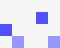

""

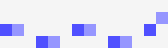

""

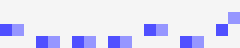

In [29]:
_ = day11(s1, visualize=True)
_ = day11(puzzle.input, part2=False, visualize=True)
# _ = day11(puzzle.input, part2=True, visualize=True)

In [22]:
# hh.analyze_lru_caches(globals())

# day11_disallowed                     14_418/inf        1.000 hit=   35_813_906 miss=       14_418


In [25]:
# hh.prun(lambda: day11(puzzle.input), top=10)

<a name="day12"></a>
## Day 12: Interpret program

- Part 1: After executing the assembunny code in your puzzle input, what value is left in register a?

- Part 2: If you instead initialize register c to be 1, what value is now left in register a?

In [52]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2016/day/12), `puzzle.input` has 23 lines:

cpy 1 a
cpy 1 b
cpy 26 d
jnz c 2
jnz 1 5
cpy 7 c
inc d
dec c
 ...
dec d
jnz d -2
dec c
jnz c -5


The stored answers are: `{1: '318020', 2: '9227674'}`

In [53]:
s1 = """\
cpy 41 a
inc a
inc a
dec a
jnz a 2
dec a
"""

In [54]:
if sys.version_info >= (3, 10):  # Using match/case.
  # pylint: disable-next=exec-used
  exec(
      """
def day12a(s, *, part2=False):
  instructions = [line.split() for line in s.splitlines()]
  registers = collections.defaultdict(int)
  if part2:
    registers['c'] = 1
  pc = 0

  def get_value(src: str) -> int:
    return registers[src] if src.isalpha() else int(src)

  while 0 <= pc < len(instructions):
    match instructions[pc]:
      case 'cpy', src, dst:
        registers[dst] = get_value(src)
      case 'inc', register:
        registers[register] += 1
      case 'dec', register:
        registers[register] -= 1
      case 'jnz', predicate, offset:
        if get_value(predicate) != 0:
          pc += int(offset) - 1
      case x:
        raise AssertionError(x)
    pc += 1

  assert set(registers) <= set('abcd')
  return registers['a']

check_eq(day12a(s1), 42)
puzzle.verify(1, day12a)  # ~0.2 s.

day12a_part2 = functools.partial(day12a, part2=True)
# puzzle.verify(2, day12a_part2)  # ~5.5 s.
  """
  )

(Part 1: 0.193 s)


In [55]:
def day12(s, *, part2=False):  # Disappointingly not much faster.
  registers = [0] * 4
  if part2:
    registers[2] = 1
  pc = 0

  def get_register(operand):
    return 'abcd'.index(operand)

  def cpy_reg(src, dst):
    nonlocal registers
    registers[dst] = registers[src]

  def cpy_val(value, dst):
    nonlocal registers
    registers[dst] = value

  def increment(register):
    nonlocal registers
    registers[register] += 1

  def decrement(register):
    nonlocal registers
    registers[register] -= 1

  def jnz_reg(register, offset):
    nonlocal registers, pc
    if registers[register] != 0:
      pc += offset - 1

  def jump(offset):
    nonlocal pc
    pc += offset - 1

  instructions: list[Callable[[], None]] = []
  for line in s.splitlines():
    operation, *args = line.split()
    if operation == 'cpy':
      if args[0].isalpha():
        instructions.append(
            functools.partial(cpy_reg, src=get_register(args[0]), dst=get_register(args[1]))
        )
      else:
        instructions.append(
            functools.partial(cpy_val, value=int(args[0]), dst=get_register(args[1]))
        )
    elif operation == 'inc':
      instructions.append(functools.partial(increment, register=get_register(args[0])))
    elif operation == 'dec':
      instructions.append(functools.partial(decrement, register=get_register(args[0])))
    elif operation == 'jnz':
      if args[0].isalpha():
        instructions.append(
            functools.partial(jnz_reg, register=get_register(args[0]), offset=int(args[1]))
        )
      elif int(args[0]) != 0:
        instructions.append(functools.partial(jump, offset=int(args[1])))
      else:
        instructions.append(lambda: None)
    else:
      raise AssertionError(line)

  while 0 <= pc < len(instructions):
    instructions[pc]()
    pc += 1

  return registers[0]


check_eq(day12(s1), 42)
puzzle.verify(1, day12)  # ~0.16 s.

day12_part2 = functools.partial(day12, part2=True)
puzzle.verify(2, day12_part2)  # ~4.6 s.

(Part 1: 0.174 s)
(Part 2: 6.158 s)


<a name="day13"></a>
## Day 13: Path in procedural maze

- Part 1: What is the fewest number of steps required for you to reach 31,39 (from 1,1) ?

- Part 2: How many locations (distinct x,y coordinates, including your starting location) can you reach in at most 50 steps?

In [56]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2016/day/13), `puzzle.input` has a single line of 4 characters:

1364


The stored answers are: `{1: '86', 2: '127'}`

In [57]:
def day13(s, *, part2=False, src_yx=(1, 1), dst_yx=(39, 31), visualize=False):
  seed = int(s)
  sentinel = -1, -1

  def is_wall(y: int, x: int) -> bool:
    value = x * x + 3 * x + 2 * x * y + y + y * y + seed
    return bin(value).count('1') % 2 != 0

  previous = {src_yx: sentinel}
  queue = collections.deque([(src_yx, 0)])

  while queue:
    (y, x), distance = queue.popleft()
    if (not part2 and (y, x) == dst_yx) or (part2 and distance == 50):
      break
    for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
      yx2 = y2, x2 = y + dy, x + dx
      if y2 >= 0 and x2 >= 0 and yx2 not in previous and not is_wall(y2, x2):
        previous[yx2] = (y, x)
        queue.append((yx2, distance + 1))

  if visualize:
    shape = 50, 60
    grid = np.array([not is_wall(y, x) for y, x in np.ndindex(shape)]).reshape(shape)
    image = media.to_rgb(grid * 0.6, vmin=0, vmax=1)
    if part2:
      image[tuple(zip(*previous))] = 1.0, 1.0, 1.0
    else:
      image[dst_yx] = 1.0, 0.0, 0.0
      yx = previous[dst_yx]
      while yx != sentinel:
        image[yx] = 1.0, 1.0, 1.0
        yx = previous[yx]
    image[src_yx] = 0.0, 1.0, 0.0
    image = np.pad(image, ((1, 0), (1, 0), (0, 0))).repeat(5, axis=0).repeat(5, axis=1)
    media.show_image(image)

  return len(previous) if part2 else distance


check_eq(day13('10', dst_yx=(4, 7)), 11)
puzzle.verify(1, day13)

day13_part2 = functools.partial(day13, part2=True)
puzzle.verify(2, day13_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


""

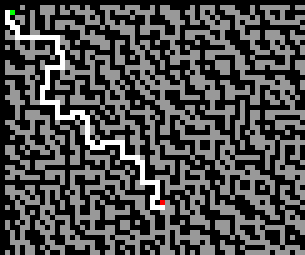

""

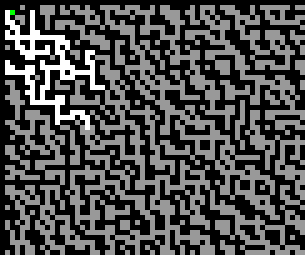

In [58]:
_ = day13(puzzle.input, visualize=True)
_ = day13_part2(puzzle.input, visualize=True)

<a name="day14"></a>
## Day 14: MD5 with repeated chars

- Part 1: Given the actual salt in your puzzle input, what index produces your 64th one-time pad key?

- Part 2: Given the actual salt in your puzzle input and using 2016 extra MD5 calls of key stretching, what index now produces your 64th one-time pad key?

In [59]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2016/day/14), `puzzle.input` has a single line of 8 characters:

yjdafjpo


The stored answers are: `{1: '25427', 2: '22045'}`

In [60]:
def day14_find_triplet(hash: str) -> str:
  for index, ch in enumerate(hash[:-2]):
    if ch == hash[index + 1] == hash[index + 2]:
      return ch
  return ''

In [61]:
def day14a(s, *, part2=False):
  s = s.strip()

  def get_hash(index: int) -> str:
    hash = hashlib.md5((s + str(index)).encode()).hexdigest()
    if part2:
      for _ in range(2016):
        hash = hashlib.md5(hash.encode()).hexdigest()
    return hash

  hashes = [get_hash(index) for index in range(1000)]

  num_found = 0
  for index in itertools.count():
    hashes.append(get_hash(len(hashes)))
    ch = day14_find_triplet(hashes[index])
    if ch and any(ch * 5 in hash for hash in hashes[index + 1 : index + 1001]):
      num_found += 1
      if num_found == 64:
        return index


check_eq(day14a('abc'), 22728)
puzzle.verify(1, day14a)

day14_part2a = functools.partial(day14a, part2=True)
# check_eq(day14a_part2('abc'), 22551)  # ~18 s.
# puzzle.verify(2, day14a_part2)  # ~17.4 s

(Part 1: 0.256 s)


In [62]:
# Faster multiprocessing solution.
def day14_get_part2_hash(s: str) -> str:
  hash = hashlib.md5(s.encode()).hexdigest()
  for _ in range(2016):
    hash = hashlib.md5(hash.encode()).hexdigest()
  return hash


def day14_part2(s):
  s = s.strip()

  with multiprocessing.Pool() as pool:
    hashes: list[str] = []

    def replenish_hashes(group_size=2400, chunksize=100):
      strings = [s + str(index) for index in range(len(hashes), len(hashes) + group_size)]
      new_hashes = pool.map(day14_get_part2_hash, strings, chunksize)
      hashes.extend(new_hashes)

    num_found = 0
    for index in itertools.count():
      if len(hashes) < index + 1001:
        replenish_hashes()
      ch = day14_find_triplet(hashes[index])
      if ch and any(ch * 5 in hash for hash in hashes[index + 1 : index + 1001]):
        num_found += 1
        if num_found == 64:
          return index


# check_eq(day14_part2('abc'), 22551)  # ~2 s.
puzzle.verify(2, day14_part2)  # ~1.9 s

(Part 2: 2.796 s)


<a name="day15"></a>
## Day 15: Spinning disks

- Part 1: What is the first time you can press the button to get a capsule?

- Part 2: A new disc with 11 positions and starting at position 0 has appeared exactly one second below the previously-bottom disc.

In [63]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2016/day/15), `puzzle.input` has 6 lines:

Disc #1 has 17 positions; at time=0, it is at position 1.
Disc #2 has 7 positions; at time=0, it is at position 0.
Disc #3 has 19 positions; at time=0, it is at position 2.
Disc #4 has 5 positions; at time=0, it is at position 0.
Disc #5 has 3 positions; at time=0, it is at position 0.
Disc #6 has 13 positions; at time=0, it is at position 5.


The stored answers are: `{1: '317371', 2: '2080951'}`

In [64]:
s1 = """\
Disc #1 has 5 positions; at time=0, it is at position 4.
Disc #2 has 2 positions; at time=0, it is at position 1.
"""

In [65]:
def day15(s, *, part2=False):
  @dataclasses.dataclass
  class Wheel:
    period: int
    phase: int  # Phase of wheel if ball released at time 0.

  wheels = []
  for line in s.splitlines():
    pattern = r'Disc #(\d+) has (\d+) positions; at time=0, it is at position (\d+)\.'
    disc, period, phase = map(int, hh.re_groups(pattern, line))
    wheels.append(Wheel(period, (phase + disc) % period))

  if part2:
    disc, period, phase = disc + 1, 11, 0
    wheels.append(Wheel(period, (phase + disc) % period))

  for time in itertools.count():
    if all((time + wheel.phase) % wheel.period == 0 for wheel in wheels):
      return time

  return None


check_eq(day15(s1), 5)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
puzzle.verify(2, day15_part2)

(Part 1: 0.088 s)
(Part 2: 0.565 s)


<a name="day16"></a>
## Day 16: Dragon grammar checksum

- Part 1: The first disk you have to fill has length 272. Using the initial state in your puzzle input, what is the correct checksum?

- Part 2: The second disk you have to fill has length 35651584. Again using the initial state in your puzzle input, what is the correct checksum for this disk?

In [66]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2016/day/16), `puzzle.input` has a single line of 17 characters:

01000100010010111


The stored answers are: `{1: '10010010110011010', 2: '01010100101011100'}`

In [67]:
def day16(s, *, length=272):
  s = s.strip()
  complement_digits = str.maketrans('01', '10')

  while len(s) < length:
    s = s + '0' + s.translate(complement_digits)[::-1]
  s = s[:length]

  while len(s) % 2 == 0:
    s = ''.join('1' if a == b else '0' for a, b in zip(s[::2], s[1::2]))

  return s


check_eq(day16('10000', length=20), '01100')
puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, length=35_651_584)
puzzle.verify(2, day16_part2)

(Part 1: 0.000 s)
(Part 2: 2.293 s)


<a name="day17"></a>
## Day 17: MD5 2D grid of doors

- Part 1: Given your vault's passcode, what is the shortest path (the actual path, not just the length) to reach the vault?

- Part 2: What is the length of the longest path that reaches the vault?  (A path cannot pass through the bottom-right room.)

In [68]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2016/day/17), `puzzle.input` has a single line of 8 characters:

pvhmgsws


The stored answers are: `{1: 'DRRDRLDURD', 2: '618'}`

In [69]:
def day17(s, *, part2=False):
  s = s.strip()
  door_map = [(-1, 0, 'U'), (1, 0, 'D'), (0, -1, 'L'), (0, 1, 'R')]

  if not part2:
    queue = collections.deque([(0, 0, '')])
    while True:
      y, x, path = queue.popleft()
      if (y, x) == (3, 3):
        return path
      hashed = hashlib.md5((s + path).encode()).hexdigest()[:4]
      is_open_udlr = ['b' <= ch <= 'f' for ch in hashed]
      for is_open, (dy, dx, step) in zip(is_open_udlr, door_map):
        y2, x2 = y + dy, x + dx
        if is_open and 0 <= y2 <= 3 and 0 <= x2 <= 3:
          queue.append((y2, x2, path + step))

  max_length = 0
  stack = [(0, 0, '')]
  while stack:
    y, x, path = stack.pop()
    if (y, x) == (3, 3):
      max_length = max(max_length, len(path))
      continue
    hashed = hashlib.md5((s + path).encode()).hexdigest()[:4]
    is_open_udlr = ['b' <= ch <= 'f' for ch in hashed]
    for is_open, (dy, dx, step) in zip(is_open_udlr, door_map):
      y2, x2 = y + dy, x + dx
      if is_open and 0 <= y2 <= 3 and 0 <= x2 <= 3:
        stack.append((y2, x2, path + step))

  return max_length


check_eq(day17('ihgpwlah'), 'DDRRRD')
check_eq(day17('kglvqrro'), 'DDUDRLRRUDRD')
check_eq(day17('ulqzkmiv'), 'DRURDRUDDLLDLUURRDULRLDUUDDDRR')
puzzle.verify(1, day17)

day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2('ihgpwlah'), 370)
check_eq(day17_part2('kglvqrro'), 492)
check_eq(day17_part2('ulqzkmiv'), 830)
puzzle.verify(2, day17_part2)

(Part 1: 0.000 s)
(Part 2: 0.088 s)


<a name="day18"></a>
## Day 18: Substring manipulation

- Part 1: Starting with the map in your puzzle input, in a total of 40 rows (including the starting row), how many safe tiles are there?

- Part 2: How many safe tiles are there in a total of 400000 rows?

In [70]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2016/day/18), `puzzle.input` has a single line of 100 characters:

...^^^^^..^...^...^^^^^^...^.^^^.^.^.^^.^^^.....^.^^^...^^^^^^.....^.^^...^^^^^...^.^^^.^^......^^^^


The stored answers are: `{1: '1982', 2: '20005203'}`

In [71]:
def day18a(s, *, num_rows=40):  # Using string manipulation.
  s = s.strip()
  assert all(ch in '.^' for ch in s), s
  num_safe = 0
  for _ in range(num_rows):
    num_safe += s.count('.')
    s = ''.join(
        '.^'[''.join(lcr) in ('^^.', '.^^', '^..', '..^')]
        for lcr in more_itertools.sliding_window('.' + s + '.', 3)
    )
  return num_safe


check_eq(day18a('..^^.', num_rows=3), 6)
check_eq(day18a('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18a)

day18a_part2 = functools.partial(day18a, num_rows=400_000)
if 0:
  puzzle.verify(2, day18a_part2)

(Part 1: 0.001 s)


In [72]:
def day18b(s, *, num_rows=40):  # Using numpy.
  state = np.array([False] + [ch == '^' for ch in s.strip()] + [False])
  num_safe = 0
  for _ in range(num_rows):
    num_safe += np.sum(~state[1:-1])
    state[1:-1] = state[2:] ^ state[:-2]
  return num_safe


check_eq(day18b('..^^.', num_rows=3), 6)
check_eq(day18b('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18b)

day18b_part2 = functools.partial(day18b, num_rows=400_000)
puzzle.verify(2, day18b_part2)

(Part 1: 0.000 s)
(Part 2: 1.865 s)


In [73]:
@numba.njit  # Using numba; 1000x speedup.
def day18_process(state, num_rows):
  num_safe = 0
  state2 = state.copy()

  for _ in range(num_rows):
    for i in range(1, len(state) - 1):
      num_safe += not state[i]
      state2[i] = state[i - 1] ^ state[i + 1]
    state, state2 = state2, state

  return num_safe


def day18(s, *, num_rows=40):
  state = np.array([False] + [ch == '^' for ch in s.strip()] + [False])
  return day18_process(state, num_rows)


check_eq(day18('..^^.', num_rows=3), 6)
check_eq(day18('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, num_rows=400_000)
if using_numba:
  puzzle.verify(2, day18_part2)

(Part 1: 0.000 s)
(Part 2: 0.065 s)


<a name="day19"></a>
## Day 19: Gift stealing across circle

- Part 1: Elves take turns stealing all the presents from the Elf to their left.  With the number of Elves given in your puzzle input, which Elf gets all the presents?

- Part 2: Elves steal presents from the Elf directly across the circle.  With the number of Elves given in your puzzle input, which Elf now gets all the presents?

In [74]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2016/day/19), `puzzle.input` has a single line of 7 characters:

3017957


The stored answers are: `{1: '1841611', 2: '1423634'}`

In [75]:
def day19a_part1(s):
  n = int(s)
  queue = collections.deque(range(1, n + 1))
  while len(queue) > 1:
    queue.rotate(-1)
    queue.popleft()
  return queue.pop()


check_eq(day19a_part1('5'), 3)
puzzle.verify(1, day19a_part1)

(Part 1: 0.327 s)


In [76]:
def day19a_part1_find_pattern():
  for i in range(2, 33):
    hh.show(i, day19a_part1(str(i)))


if 0:
  day19a_part1_find_pattern()

In [77]:
def day19_part1(s):  # Analytic solution derived from pattern detected above.
  n = int(s)
  # Pattern for function f(n):
  # If 2**(k-1) < n <= 2**k, then f(n) = (n - 2**(k-1)) * 2 + 1
  k = math.ceil(math.log(n) / math.log(2))
  return (n - 2 ** (k - 1)) * 2 + 1


check_eq(day19_part1('5'), 3)
puzzle.verify(1, day19_part1)

(Part 1: 0.000 s)


In [78]:
def day19a_part2(s):  # Impractical quadratic complexity.
  num = int(s)
  queue = collections.deque(range(1, num + 1))
  while len(queue) > 1:
    across = len(queue) // 2
    queue.rotate(-across)
    queue.popleft()
    queue.rotate(across - 1)  # -1 to advance to left
  return queue.pop()


check_eq(day19a_part2('5'), 2)
# puzzle.verify(2, day19_part2)  # Impossibly slow.


def day19a_part2_find_pattern():
  for i in range(2, 30):
    hh.show(i, day19_part2(str(i)))


if 0:
  day19a_part2_find_pattern()

In [79]:
def day19_part2(s):  # Analytic solution derived from pattern detected above.
  n = int(s)
  # Pattern for function f(n):
  # We can always find k such that 3**(k-1) < n <= 3**k.
  # If 3**(k-1) < n <= 2 * 3**(k-1), then f(n) = n - 3**(k-1).
  # If 2 * 3**(k-1) < n <= 3**k,     then f(n) = n * 2 - 3**k.
  k = math.ceil(math.log(n) / math.log(3))
  return n - 3 ** (k - 1) if n <= 2 * 3 ** (k - 1) else n * 2 - 3**k


check_eq(day19_part2('5'), 2)
puzzle.verify(2, day19_part2)

(Part 2: 0.000 s)


<a name="day20"></a>
## Day 20: Disallowed integer ranges

- Part 1: Given the list of blocked IPs you retrieved from the firewall (your puzzle input), what is the lowest-valued IP that is not blocked?

- Part 2: How many IPs are allowed by the blacklist?

In [80]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2016/day/20), `puzzle.input` has 945 lines:

2803551464-2812875810
3863319608-3871068145
881357481-892360003
1109987968-1119969449
3658860150-3661459953
3315323905-3317364128
4198570301-4213558177
3652285991-3657587289
 ...
3529743404-3545604807
3180438225-3183736951
3233823029-3240497576
3401028250-3405865033


The stored answers are: `{1: '14975795', 2: '101'}`

In [81]:
s1 = """\
5-8
0-2
4-7
"""

In [82]:
def day20_part1(s):  # Fast search over sorted candidates just below disallowed ranges; O(k^2).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]
  candidates = sorted(start - 1 for start, _ in disallowed if start > 0)
  for x in candidates:
    if not any(start <= x < stop for start, stop in disallowed):
      return x
  raise AssertionError


check_eq(day20_part1(s1), 3)
puzzle.verify(1, day20_part1)

(Part 1: 0.001 s)


In [83]:
def day20a_part2(s, *, stop=2**32):  # Brute-force numpy array; O(stop * k).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]
  array = np.full(stop, True)
  for start0, stop0 in disallowed:
    array[start0:stop0] = False
  return np.sum(array)


check_eq(day20a_part2(s1, stop=10), 2)
if 0:
  puzzle.verify(2, day20a_part2)  # Slow; ~3.3 s.

In [84]:
def day20b_part2(s, *, stop=2**32):  # Binary subdivision; O(max(k, log(stop)) * k).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]

  def count_allowed(start: int, stop: int) -> int:
    if any(start >= start0 and stop <= stop0 for start0, stop0 in disallowed):
      return 0
    if all(start >= stop0 or stop <= start0 for start0, stop0 in disallowed):
      return stop - start
    mid = (start + stop) // 2
    assert start < mid < stop
    return count_allowed(start, mid) + count_allowed(mid, stop)

  return count_allowed(0, stop)


check_eq(day20b_part2(s1, stop=10), 2)
puzzle.verify(2, day20b_part2)

(Part 2: 0.225 s)


In [85]:
def day20_part2(s, *, size=2**32):  # Iteratively update list of allowed regions.
  allowed = [(0, size)]
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]

  for start0, stop0 in disallowed:
    allowed2 = []
    for start, stop in allowed:
      if stop0 <= start or start0 >= stop:
        allowed2.append((start, stop))
      elif start0 <= start and stop0 >= stop:
        pass
      elif start0 > start and stop0 < stop:
        allowed2.append((start, start0))
        allowed2.append((stop0, stop))
      elif start0 <= start:
        allowed2.append((max(start, stop0), stop))
      else:
        allowed2.append((start, min(stop, start0)))
    allowed = allowed2

  return sum(stop - start for start, stop in allowed)


check_eq(day20_part2(s1, size=10), 2)
puzzle.verify(2, day20_part2)

(Part 2: 0.007 s)


<a name="day21"></a>
## Day 21: Successive scrambling of string

- Part 1: Given the list of scrambling operations in your puzzle input, what is the result of scrambling abcdefgh?

- Part 2: What is the un-scrambled version of the scrambled password fbgdceah?

In [86]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2016/day/21), `puzzle.input` has 100 lines:

rotate right 4 steps
swap letter b with letter e
swap position 1 with position 3
reverse positions 0 through 4
rotate left 5 steps
swap position 6 with position 5
move position 3 to position 2
move position 6 to position 5
 ...
rotate based on position of letter f
rotate left 7 steps
rotate based on position of letter e
swap position 6 with position 1


The stored answers are: `{1: 'dbfgaehc', 2: 'aghfcdeb'}`

In [87]:
s1 = """\
swap position 4 with position 0
swap letter d with letter b
reverse positions 0 through 4
rotate left 1 step
move position 1 to position 4
move position 3 to position 0
rotate based on position of letter b
rotate based on position of letter d
"""

In [88]:
def day21(s, *, initial=None, part2=False, debug=False):
  lines = s.splitlines()
  initial = initial or ('fbgdceah' if part2 else 'abcdefgh')
  state = list(initial)
  num = len(state)
  # Index of letter at index after "rotate based on position of letter"; used for inversion.
  rotate_on_letter = [(index + (1 + index + (index >= 4))) % num for index in range(num)]

  def scramble1(state: list[str], line: str, invert: bool) -> list[str]:
    if match := re.fullmatch(r'swap position (\d+) with position (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert 0 <= i0 < num and 0 <= i1 < num and i0 != i1
      state[i0], state[i1] = state[i1], state[i0]
    elif match := re.fullmatch(r'swap letter (\w) with letter (\w)', line):
      ch0, ch1 = match.groups()
      assert ch0 != ch1
      i0, i1 = state.index(ch0), state.index(ch1)
      state[i0], state[i1] = ch1, ch0
    elif match := re.fullmatch(r'rotate (left|right) (\d+) steps?', line):
      direction, delta = match.group(1), int(match.group(2))
      if invert:
        direction = 'left' if direction == 'right' else 'right'
      assert 0 <= delta < num
      delta = -delta % num if direction == 'right' else delta
      state = state[delta:] + state[:delta]  # Rotate left by delta (which can be 0).
    elif match := re.fullmatch(r'rotate based on position of letter (\w)', line):
      (ch,) = match.groups()
      index = state.index(ch)
      if invert:
        (index2,) = [i0 for i0, i1 in enumerate(rotate_on_letter) if i1 == index]
        delta = (1 + index2 + (index2 >= 4)) % num
        check_eq((index2 + delta) % num, index)
      else:
        delta = -(1 + index + (index >= 4)) % num  # Rotate right is negative delta.
      state = state[delta:] + state[:delta]  # Rotate left by delta (which can be 0).
      # index -> (index - delta) % num.
    elif match := re.fullmatch(r'reverse positions (\d+) through (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert i0 <= i1
      state[i0 : i1 + 1] = reversed(state[i0 : i1 + 1])
    elif match := re.fullmatch(r'move position (\d+) to position (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert 0 <= i0 < num and 0 <= i1 < num and i0 != i1
      if invert:
        i0, i1 = i1, i0
      ch = state[i0]
      state = state[:i0] + state[i0 + 1 :]
      state = state[:i1] + [ch] + state[i1:]
    else:
      raise AssertionError(line)
    return state

  def scramble(state: list[str], lines: list[str], invert: bool) -> list[str]:
    lines2 = lines[::-1] if invert else lines
    for line in lines2:
      if invert and debug:
        assert scramble1(scramble1(state.copy(), line, True), line, False) == state, line
      state = scramble1(state, line, invert)
    return state

  state = scramble(state, lines, part2)
  return ''.join(state)


check_eq(day21(s1, initial='abcde'), 'decab')
puzzle.verify(1, day21)

day21_part2 = functools.partial(day21, part2=True)
_ = day21_part2(puzzle.input, debug=True)
puzzle.verify(2, day21_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day22"></a>
## Day 22: Grid of storage disks

- Part 1: How many viable pairs (A is not empty; A != B; data of A would fit on B) of nodes are there?

- Part 2: What is the fewest number of steps required to move your goal data to node-x0-y0?

(Note: the puzzle description has bugs; it refers to `node-y0-x1` rather than `node-x1-y0`.)

In [89]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2016/day/22), `puzzle.input` has 992 lines:

root@ebhq-gridcenter# df -h
Filesystem              Size  Used  Avail  Use%
/dev/grid/node-x0-y0     88T   67T    21T   76%
/dev/grid/node-x0-y1     85T   73T    12T   85%
/dev/grid/node-x0-y2     94T   73T    21T   77%
/dev/grid/node-x0-y3     91T   72T    19T   79%
/dev/grid/node-x0-y4     93T   71T    22T   76%
/dev/grid/node-x0-y5     87T   65T    22T   74%
 ...
/dev/grid/node-x32-y26   89T   72T    17T   80%
/dev/grid/node-x32-y27  501T  496T     5T   99%
/dev/grid/node-x32-y28   88T   73T    15T   82%
/dev/grid/node-x32-y29   90T   65T    25T   72%


The stored answers are: `{1: '960', 2: '225'}`

In [90]:
def day22(s, *, part2=False, debug=False):
  lines = s.splitlines()[2:]
  shape = tuple(int(e) + 1 for e in hh.re_groups(r'node-x(\d+)-y(\d+)\s', lines[-1]))[::-1]  # y, x
  check_eq(len(lines), math.prod(shape))
  size, used, avail = np.full(shape, -1), np.full(shape, -1), np.full(shape, -1)
  for line in lines:
    pattern = r'^/dev/grid/node-x(\d+)-y(\d+)\s+(\d+)T\s+(\d+)T\s+(\d+)T\s+\d+%$'
    x, y, size1, used1, avail1 = map(int, hh.re_groups(pattern, line))
    size[y, x], used[y, x], avail[y, x] = size1, used1, avail1

  # Assumptions:
  assert size.min() >= 0 and used.min() >= 0 and avail.min() >= 0  # Loaded data is complete.
  assert (used == 0).sum() == 1  # There is only one free node.
  assert used[0, -1] < size.min()  # All nodes can hold the (upper-right) data.
  assert used[used > 0].min() > avail[used > 0].max()  # Data can only transfer to the free node.
  large_value = used[used > size.min()].min()
  large = used >= large_value
  assert size[~large].max() < large_value  # Data from large nodes can never move.
  assert np.all(~large[0])  # There are no large nodes on the topmost grid row.

  if debug:
    hh.show(used[0, -1], size.min(), large_value, used[used > 0].min(), avail[used > 0].max())
    with np.printoptions(linewidth=1000):
      print(f'size:\n{size}\nused:\n{used}\navail:\n{avail}')

  if not part2:
    if 0:  # Slow.
      return sum(
          1
          for x0, y0 in np.ndindex(shape)
          for x1, y1 in np.ndindex(shape)
          if (x0 != x1 or y0 != y1) and used[x0, y0] > 0 and used[x0, y0] <= avail[x1, y1]
      )
    return used.size - 1 - large.sum()

  # I initially solved Part 2 using paper and pencil!

  # Compute the length of the shortest path from the free node to the node left of the upper-right.
  ((y0, x0),) = np.argwhere(used == 0)
  queue = collections.deque([(y0, x0, 0)])
  seen = set()
  while True:
    y, x, length = queue.popleft()
    if (y, x) == (0, shape[1] - 2):  # Node to the left of the upper-right node.
      break
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
      y2, x2 = y + dy, x + dx
      if 0 <= y2 < shape[0] and 0 <= x2 < shape[1] and not large[y2, x2] and (y2, x2) not in seen:
        seen.add((y2, x2))
        queue.append((y2, x2, length + 1))

  # Add the motions to move the data on the upper row.
  length += 1 + (4 + 1) * (shape[1] - 2)

  return length


puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
puzzle.verify(2, day22_part2)

(Part 1: 0.002 s)
(Part 2: 0.005 s)


<a name="day23"></a>
## Day 23: Program with toggle instruction

- Part 1: Place 7 in register a, run the code.  What is the value left in register a?

- Part 2: Place 12 in register a, run the code.  What is the value left in register a?

In [91]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2016/day/23), `puzzle.input` has 26 lines:

cpy a b
dec b
cpy a d
cpy 0 a
cpy b c
inc a
dec c
jnz c -2
 ...
inc d
jnz d -2
inc c
jnz c -5


The stored answers are: `{1: '12071', 2: '479008631'}`

In [92]:
s1 = """\
cpy 2 a
tgl a
tgl a
tgl a
cpy 1 a
dec a
dec a
"""

In [93]:
def day23(s, *, part2=False, debug=False):
  def compute(initial_a: int) -> int:
    instructions = [line.split() for line in s.splitlines()]
    registers = collections.defaultdict(int)
    registers['a'] = initial_a
    pc = 0

    def get_value(src: str) -> int:
      return registers[src] if src.isalpha() else int(src)

    while 0 <= pc < len(instructions):
      match instructions[pc]:
        case 'cpy', src, dst:
          if dst.isalpha():
            registers[dst] = get_value(src)
        case 'inc', register:
          if register.isalpha():
            registers[register] += 1
        case 'dec', register:
          if register.isalpha():
            registers[register] -= 1
        case 'jnz', predicate, offset:
          if get_value(predicate) != 0:
            pc += get_value(offset) - 1
        case 'tgl', register:
          assert register.isalpha()
          pc2 = pc + registers[register]
          if debug:
            hh.show('tgl', pc, registers, pc2)
          if 0 <= pc2 < len(instructions):
            instruction = instructions[pc2]
            old_instruction = instruction.copy()
            match instruction:
              case 'inc', _:
                instruction[0] = 'dec'
              case _, _:
                instruction[0] = 'inc'
              case 'jnz', _, _:
                instruction[0] = 'cpy'
              case _, _, _:
                instruction[0] = 'jnz'
            if debug:
              hh.show(pc2, old_instruction, instruction)
          if registers['b'] > 1 and not debug:  # Multiplication optimization.
            check_eq(pc, 16)
            registers['a'] *= registers['b']
            registers['b'] -= 1
            registers['c'] -= 2
            pc -= 1
        case x:
          raise AssertionError(x)
      pc += 1

    assert set(registers) <= set('abcd')
    return registers['a']

  if debug:
    for initial_a in range(6, 10):
      hh.show(initial_a, compute(initial_a))
    raise hh.StopExecution

  return compute(12 if part2 else 7)


check_eq(day23(s1), 3)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
puzzle.verify(2, day23_part2)

(Part 1: 0.005 s)
(Part 2: 0.005 s)


In [94]:
if 0:
  _ = day23(puzzle.input, debug=True)

In [95]:
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 30, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 120, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 360, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 720, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 6, compute(initial_a) = 7751
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 42, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 210, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 840, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 2520, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 5040, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 7, compute(initial_a) = 12071
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 56, 'b': 6, 'd': 0, 'c': 12}), pc2 = 28
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 336, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 1680, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 6720, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 20160, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 40320, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 8, compute(initial_a) = 47351
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 72, 'b': 7, 'd': 0, 'c': 14}), pc2 = 30
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 504, 'b': 6, 'd': 0, 'c': 12}), pc2 = 28
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 3024, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 15120, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 60480, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 181440, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, pc = 16, registers = defaultdict(<class 'int'>, {'a': 362880, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 9, compute(initial_a) = 369911
# <StopExecution>

<a name="day24"></a>
## Day 24: Path visiting all maze nodes

- Part 1: Given your actual map, and starting from location 0, what is the fewest number of steps required to visit every non-0 number marked on the map at least once?

- Part 2: What is the fewest number of steps required to start at 0, visit every non-0 number marked on the map at least once, and then return to 0?

In [96]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2016/day/24), `puzzle.input` has 41 lines:

################################################################################ ... ###################################
#.#.......#.#.#.....#.#.......#.................#.......#.#.....#.....#...#...#. ... ........#.....#.#.............#...#
#.#####.#.#.#.#.#.#.#.#.#.###.#.#.###.#.#.###.###.#.#.#.#.#.#####.#.#.###.#.#.## ... #.#.#.#.#.#.#.#.#.###.#####.#.###.#
#.....#.............#...#....6#.....#.....#.#...#.....#...#.........#.......#... ... #.........#.....#...#.#.#.#.....#.#
#####.#.###.###.#.#.#.#####.#.#####.#.#####.#.#######.#.#.#.#.#.#####.#####.#.## ... #.#.#.#.#.#.###########.#.#.#####.#
#.....#.......#.#.....#.......#.#...#.#.#.#...........#.....#.#.#...#.#...#.#.#. ... #.....#...#.......#.#...#.#.....#.#
###.#.#.#.#####.#####.#.#.#.#.#.#.#.#.#.#.#########.#.#########.#.#.###.###.###. ... #.#.#.###.###.#.#.#.#.#.###.#.#####
#...#...#.#.....#.............#...#...#...#.#.......#.#.#...#...#.#.#...#.....#. ... #...#.....#.#.......#.#.#...#...#.#
 ...
#.....#.....#.#............

The stored answers are: `{1: '500', 2: '748'}`

In [97]:
s1 = """\
###########
#0.1.....2#
#.#######.#
#4.......3#
###########
"""

In [98]:
def day24a(s, *, part2=False):  # Find shortest path over all permutations of nodes.
  grid = np.array([list(line) for line in s.splitlines()])
  num_nodes = np.max(grid[np.char.isdigit(grid)].astype(int)) + 1
  node_yx = [tuple(a[0]) for node in range(num_nodes) for a in [np.argwhere(grid == str(node))]]

  @functools.cache
  def get_distances(node0: int) -> dict[int, int]:
    yx = node_yx[node0]
    queue = collections.deque([(yx, 0)])
    seen = {yx}
    distances = {}
    while queue:
      yx, distance = queue.popleft()
      if grid[yx].isdigit():
        distances[int(grid[yx])] = distance
      for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          queue.append((yx2, distance + 1))
    return distances

  def get_distance(node0: int, node1: int) -> int:
    return get_distances(node0)[node1]

  def path_distance(path: Iterable[int]) -> int:
    return sum(get_distance(node0, node1) for node0, node1 in more_itertools.pairwise(path))

  permutations = itertools.permutations(range(1, num_nodes))

  if not part2:
    return min(path_distance((0,) + path1) for path1 in permutations)

  return min(path_distance((0,) + path1 + (0,)) for path1 in permutations)


check_eq(day24a(s1), 14)
puzzle.verify(1, day24a)

day24a_part2 = functools.partial(day24a, part2=True)
puzzle.verify(2, day24a_part2)

(Part 1: 0.109 s)
(Part 2: 0.110 s)


In [99]:
def day24(s, *, part2=False):  # Use Dijkstra where the state includes the set of visited nodes.
  grid = np.array([list(line) for line in s.splitlines()])
  num_nodes = np.max(grid[np.char.isdigit(grid)].astype(int)) + 1
  node_yx = [tuple(a[0]) for node in range(num_nodes) for a in [np.argwhere(grid == str(node))]]

  @functools.cache
  def get_distances(node0: int) -> dict[int, int]:
    yx = node_yx[node0]
    queue = collections.deque([(yx, 0)])
    seen = {yx}
    distances = {}
    while queue:
      yx, distance = queue.popleft()
      if grid[yx].isdigit():
        distances[int(grid[yx])] = distance
      for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in seen:
          seen.add(yx2)
          queue.append((yx2, distance + 1))
    return distances

  def get_distance(node0: int, node1: int) -> int:
    return get_distances(node0)[node1]

  all_nodes = frozenset(range(1, num_nodes))
  state: tuple[int, frozenset[int]] = 0, frozenset()  # node, visited
  distances = collections.defaultdict(lambda: sys.maxsize)  # for Dijkstra
  distances[state] = 0
  priority_queue = [(0, state)]
  while priority_queue:
    _, state = heapq.heappop(priority_queue)
    node, visited = state
    distance = distances[state]
    if len(visited) == (num_nodes - (0 if part2 else 1)):
      return distance
    candidates = all_nodes - visited
    if part2 and not candidates:
      candidates = frozenset({0})  # For Part 2, complete the cycle back to the start node.
    for node2 in candidates:
      visited2 = visited | {node2}
      state2 = node2, visited2
      distance2 = distance + get_distance(node, node2)
      if distance2 < distances[state2]:
        distances[state2] = distance2
        heapq.heappush(priority_queue, (distance2, state2))

  raise AssertionError


check_eq(day24(s1), 14)
puzzle.verify(1, day24)

day24_part2 = functools.partial(day24, part2=True)
puzzle.verify(2, day24_part2)

(Part 1: 0.117 s)
(Part 2: 0.115 s)


<a name="day25"></a>
## Day 25: Program to generate clock

- Part 1: What is the lowest positive integer that can be used to initialize register a and cause the code to output a clock signal of 0, 1, 0, 1... repeating forever?

- Part 2: No Part 2 on day 25.

In [100]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2016/day/25), `puzzle.input` has 30 lines:

cpy a d
cpy 7 c
cpy 362 b
inc d
dec b
jnz b -2
dec c
jnz c -5
 ...
jnz 0 0
out b
jnz a -19
jnz 1 -21


The stored answers are: `{1: '196', 2: ''}`

In [101]:
def day25(s):
  instructions = [line.split() for line in s.splitlines()]

  def desired_output() -> Iterator[int]:
    return itertools.cycle([0, 1])

  def compute_output(initial_a: int) -> Iterator[int]:
    assert initial_a > 0
    registers = dict(a=initial_a, b=0, c=0, d=0)
    pc = 0

    def get_value(src: str) -> int:
      return registers[src] if src.isalpha() else int(src)

    while True:
      match instructions[pc]:
        case 'cpy', src, dst:
          registers[dst] = get_value(src)
        case 'inc', register:
          registers[register] += 1
        case 'dec', register:
          registers[register] -= 1
        case 'jnz', predicate, offset:
          if get_value(predicate) != 0:
            pc += get_value(offset) - 1
        case 'out', src:
          yield get_value(src)
        case x:
          raise AssertionError(x)
      pc += 1

  def equal_prefix(values1: Iterable[int], values2: Iterable[int], length: int) -> bool:
    prefix1, prefix2 = itertools.islice(values1, length), itertools.islice(values2, length)
    return all(e1 == e2 for e1, e2 in zip(prefix1, prefix2))

  if 0:
    for initial_a in range(180, 200):
      output = itertools.islice(compute_output(initial_a), 30)
      s_output = ''.join(str(value) for value in output)
      print(f'{initial_a:3} {s_output}')
    raise hh.StopExecution

  for initial_a in range(1, 2000):
    if equal_prefix(compute_output(initial_a), desired_output(), 30):
      return initial_a


puzzle.verify(1, day25)

puzzle.verify(2, lambda s: '')

(Part 1: 1.148 s)
(Part 2: 0.000 s)


In [102]:
# You activate all fifty stars and transmit the signal. The star atop the antenna begins to glow.
# Suddenly, you see the sleigh fly past you!Looks like Santa was already waiting for your signal.
# Congratulations!  You've finished every puzzle in Advent of Code 2016!
# I hope you had as much fun solving them as I had making them for you.
# I'd love to hear about your adventure; you can get in touch with me via contact info on my website or through Twitter.
# If you'd like to see more things like this in the future, please consider supporting Advent of Code and sharing it with others.
# To hear about future projects, you can follow me on Twitter.
# I've highlighted the easter eggs in each puzzle, just in case you missed any.  Hover your mouse over them, and the easter egg will appear.

<a name="timings"></a>
## Timings

In [103]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.000   part_2: 0.001
day_3    part_1: 0.002   part_2: 0.005
day_4    part_1: 0.012   part_2: 0.007
day_5    part_1: 0.806   part_2: 1.856
day_6    part_1: 0.000   part_2: 0.000
day_7    part_1: 0.017   part_2: 0.028
day_8    part_1: 0.001   part_2: 0.004
day_9    part_1: 0.000   part_2: 0.001
day_10   part_1: 0.000   part_2: 0.000
day_11   part_1: 3.337   part_2:-0.000
day_12   part_1: 0.174   part_2: 6.158
day_13   part_1: 0.000   part_2: 0.000
day_14   part_1: 0.256   part_2: 2.796
day_15   part_1: 0.088   part_2: 0.565
day_16   part_1: 0.000   part_2: 2.293
day_17   part_1: 0.000   part_2: 0.088
day_18   part_1: 0.000   part_2: 0.065
day_19   part_1: 0.000   part_2: 0.000
day_20   part_1: 0.001   part_2: 0.007
day_21   part_1: 0.000   part_2: 0.000
day_22   part_1: 0.002   part_2: 0.005
day_23   part_1: 0.005   part_2: 0.005
day_24   part_1: 0.117   part_2: 0.115
day_25   part_1: 1.148   part_2: 0.000
Total time: 19.968 s


In [104]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [105]:
if 1:  # Look for unwanted pollution of namespace.
  print(
      textwrap.fill(
          ' '.join(
              name
              for name, value in globals().items()
              if not (name.startswith(('_', 'day')) or name in _ORIGINAL_GLOBALS)
          )
      )
  )

puzzle s1 s2


In [106]:
if 0:  # Lint.
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  print('All ran.')

In [107]:
hh.show_notebook_cell_top_times()

# Total time: 33.81 s
# In[ 47] def day11a(s, *, part2=False):\n  initial_contents: list[    8.603 s
# In[ 55] def day12(s, *, part2=False):  # Disappointingly not much    6.336 s
# In[ 49] def day11(s, *, part2=False):  # Slightly faster.\n          3.347 s
# In[ 62] # Faster multiprocessing solution.\ndef day14_get_part2_     2.799 s
# In[ 29] # Faster multiprocessing solution; also, small speedups      2.670 s
# In[ 67] def day16(s, *, length=272):\n  s = s.strip()\n              2.297 s
# In[ 72] def day18b(s, *, num_rows=40):  # Using numpy.\n  state =    1.877 s
# In[101] def day25(s):\n  instructions = [line.split() for line in    1.152 s
# In[ 65] def day15(s, *, part2=False):\n  @dataclasses.dataclass\n    0.662 s
# In[  7] # (1) To obtain puzzle inputs and answers, we first try      0.543 s
# In[ 61] def day14a(s, *, part2=False):\n  s = s.strip()\n\n  def     0.498 s
# In[ 69] def day17(s, *, part2=False):\n  s = s.strip()\n  door_map   0.408 s
# In[ 73] @numba.njit  # Using

# End

In [108]:
# # Multiprocessing; hasher.copy(); digest().

# def day5_find_zero_hashes(s: str, start: int, stop: int) -> list[int]:
#   # Pool requires that this function be pickled, so it must be in global module scope.
#   if 0:  # ~15% slower.
#     return [index for index in range(start, stop)
#             if hashlib.md5((s + str(index)).encode()).hexdigest()[:5] == '00000']
#   results = []
#   hasher = hashlib.md5(s.encode())
#   for index in range(start, stop):
#     hasher2 = hasher.copy()
#     hasher2.update(str(index).encode())
#     digest = hasher2.digest()
#     if digest[:2] == b'\0\0' and digest.hex()[4] == '0':
#       results.append(index)
#   return results


# def day5_multiprocessing_generator(s: str, part2: bool) -> Iterator[int]:
#   group_size = 2_000_000 if part2 else 500_000
#   with multiprocessing.Pool() as pool:
#     for base in itertools.count(0, group_size):
#       chunk_size = group_size // multiprocessing.cpu_count() + 1
#       args = []
#       start, group_stop = base, base + group_size
#       while start < group_stop:
#         stop = min(start + chunk_size, group_stop)
#         args.append((s, start, stop))
#         start = stop
#       results = pool.starmap(day5_find_zero_hashes, args)
#       yield from more_itertools.flatten(results)


# def day5_evaluator(s: str, part2: bool, generator: Callable[[int, bool], Iterator[int]]) -> str:
#   password = ['_'] * 8 if part2 else []
#   for index in generator(s, part2):
#     hashed = hashlib.md5((s + str(index)).encode()).hexdigest()
#     check_eq(hashed[:5], '00000')
#     if part2:
#       position = int(hashed[5], 16)
#       if position < 8 and password[position] == '_':
#         password[position] = hashed[6]
#         if '_' not in password:
#           return ''.join(password)
#     else:
#       password.append(hashed[5])
#       if len(password) == 8:
#         return ''.join(password)

# def day5(s, part2=False):
#   return day5_evaluator(s, part2, day5_multiprocessing_generator)


# # check_eq(day5('abc'), '18f47a30')
# puzzle.verify(1, day5)  # ~0.5 s.

# day5_part2 = functools.partial(day5, part2=True)
# # check_eq(day5_part2('abc'), '05ace8e3')
# puzzle.verify(2, day5_part2)  # ~1.25 s.

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->